**Sequence to sequence**(gru or bigru)

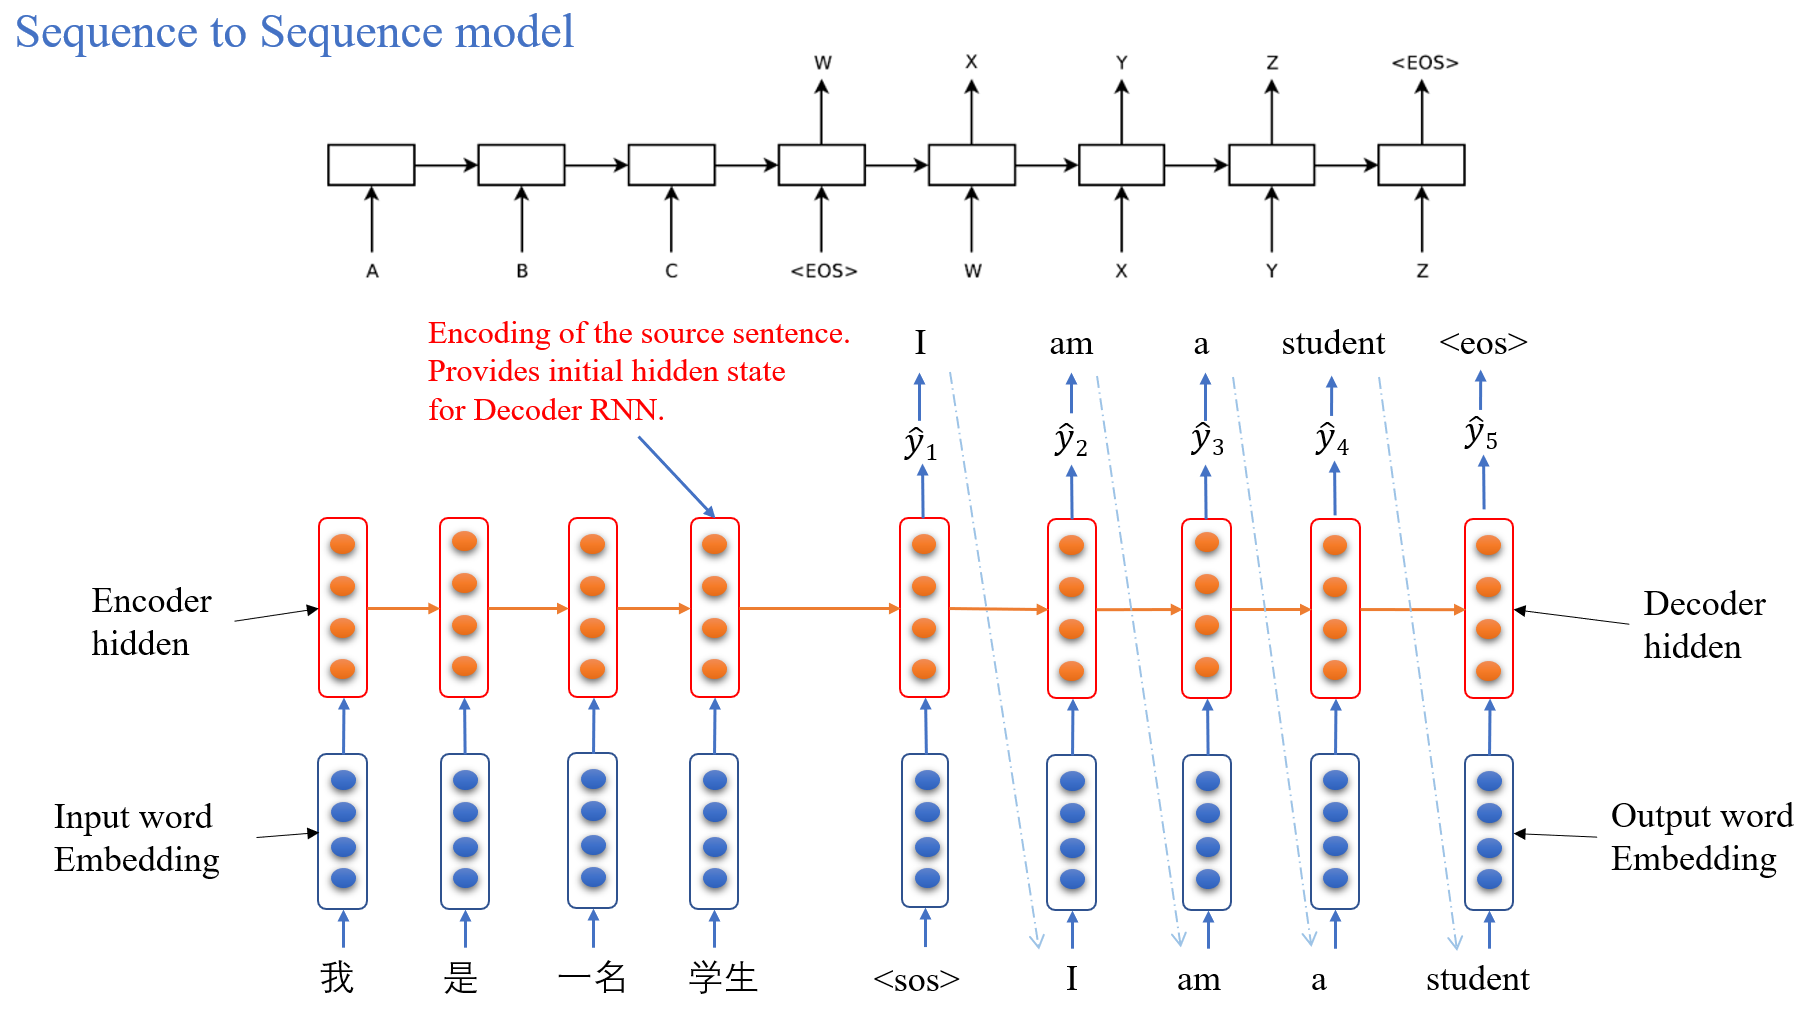

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing libraries
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [4]:
!pip install opencc
from opencc import OpenCC
import jieba
cc = OpenCC('t2s')  #将繁体转为简体

     |████████████████████████████████| 1.3MB 8.2MB/s 


In [5]:
path_to_file = '/content/drive/MyDrive/cmn.txt'

def preprocess_sentence_zh(w):
    w = w.lower().strip()
    w = cc.convert(w)  
    w = w.rstrip().strip()
    w = ' '.join(jieba.lcut(w))
    # 去除多余空格 
    w = re.sub(r'[" "]+', " ", w)
    return w

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence_en(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.

  return w

In [7]:
en_sentence = u"Please be ready in fifteen minutes."
cn_sentence = u"樂觀者在災禍中看到機會，悲觀者在機會中看到災禍。"
print(preprocess_sentence_en(en_sentence))
print(preprocess_sentence_zh(cn_sentence))

please be ready in fifteen minutes .
乐观 者 在 灾祸 中 看到 机会 ， 悲观者 在 机会 中 看到 灾祸 。


In [8]:
# Load the dataset: sentence in english, sentence in chinese
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
VOCAB_SIZE = 30000

df=pd.read_csv(path_to_file, sep="\t", header=None, names=[TARGET_COLUMN,INPUT_COLUMN], usecols=[0,1], 
               nrows=30000)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence_zh(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence_en(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence_en(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['嗨 。', '你好 。', '你 用 跑 的 。', '等等 ！', '等 一下 ！']
['hi . <eos>', 'hi . <eos>', 'run . <eos>', 'wait ! <eos>', 'wait ! <eos>']
['<sos> hi .', '<sos> hi .', '<sos> run .', '<sos> wait !', '<sos> wait !']


In [9]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

22

In [10]:
tokenizer_inputs = Tokenizer(num_words=VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
print(input_data[1022])
print(input_sequences[1022])

Max Input Length:  30
我 喜欢 跑步 。
[2, 27, 1041, 1]


In [11]:
tokenizer_outputs = Tokenizer(num_words=VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)

target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[1000])
print(target_sequences[1000])
print(target_input_data[1000])
print(target_sequences_inputs[1000])

Max Target Length:  37
i broke my arm . <eos>
[4, 485, 18, 808, 1, 2]
<sos> i broke my arm .
[3, 4, 485, 18, 808, 1]


In [12]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1
idx2word_inputs = {v:k for k,v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k,v in word2idx_outputs.items()}

Found 11321 unique input tokens.
Found 6479 unique output tokens.


In [13]:
# pad the input sequences
encoder_inputs_tensor = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs_tensor.shape:", encoder_inputs_tensor.shape)
print("encoder_inputs_tensor[0]:", encoder_inputs_tensor[0])
# pad the decoder input sequences
decoder_inputs_tensor = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs_tensor[0]:", decoder_inputs_tensor[0])
print("decoder_inputs_tensor.shape:", decoder_inputs_tensor.shape)
# pad the target output sequences
decoder_targets_tensor = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')
print('decoder_targets_tensor[0]:', decoder_targets_tensor[0])
print('decoder_targets_tensor.shape:', decoder_targets_tensor.shape)


encoder_inputs_tensor.shape: (24026, 30)
encoder_inputs_tensor[0]: [2126    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
decoder_inputs_tensor[0]: [   3 1701    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
decoder_inputs_tensor.shape: (24026, 37)
decoder_targets_tensor[0]: [1701    1    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
decoder_targets_tensor.shape: (24026, 37)


**tf.data.dataset**

In [14]:
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices((encoder_inputs_tensor, decoder_inputs_tensor, decoder_targets_tensor))
print(dataset)
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<TensorSliceDataset shapes: ((30,), (37,), (37,)), types: (tf.int32, tf.int32, tf.int32)>
<BatchDataset shapes: ((64, 30), (64, 37), (64, 37)), types: (tf.int32, tf.int32, tf.int32)>


In [15]:
#encoder为gru
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.hidden_dim, return_sequences=False, return_state=True)
  
  def call(self, input_sequence, states):
    
    embed = self.embedding(input_sequence)
    output, state = self.gru(embed, initial_state=states)

    return output, state

  def init_states(self, batch_size):
    return tf.zeros([batch_size, self.hidden_dim])

In [28]:
#encoder为双向gru
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.bigru =  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_dim, return_sequences=False, return_state=True))
  
  def call(self, input_sequence, states):
    
    embed = self.embedding(input_sequence)
    output, forward_state, backward_state = self.bigru(embed, initial_state=states)
    state = tf.keras.layers.concatenate([forward_state, backward_state])
    return output, state

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.hidden_dim]),  tf.zeros([batch_size, self.hidden_dim]))

In [29]:
#encoder: gru or bigru  decoder: gru  #bigru的话hidden_dim * 2
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim * 2 
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer
        self.gru = tf.keras.layers.GRU(
            self.hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the GRU unit
        lstm_out, state = self.gru(embed, state)
        # Dense layer to predict output token
        logits = self.dense(lstm_out)

        return logits, state

In [30]:
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 

#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
initial_state = encoder.init_states(1)
print(initial_state)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)

(<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)


In [31]:
def loss_func(targets, logits):
  crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # Mask padding values, they do not have to compute for loss
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64)
  loss = crossentropy(targets, logits, sample_weight=mask)

  return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)

    return n_correct / n_total

In [32]:
# Use the @tf.function decorator to take advance of static graph computation
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
  # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
  with tf.GradientTape() as tape:
    en_outputs = encoder(input_seq, en_initial_states)
    en_states = en_outputs[1:]
    de_states = en_states

    de_outputs = decoder(target_seq_in, de_states)
    # Take the actual output
    logits = de_outputs[0]
    loss = loss_func(target_seq_out, logits)
    acc = accuracy_fn(target_seq_out, logits)
  
  variables = encoder.trainable_variables + decoder.trainable_variables
  # Calculate the gradients for the variables
  gradients = tape.gradient(loss, variables)
  # Apply the gradients and update the optimizer
  optimizer.apply_gradients(zip(gradients, variables))

  return loss, acc

# **Teacher Forcing**
Teacher forcing is a training method critical to the development of deep learning models in NLP. It is a way for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

In a recurrent network usually the input to a RNN at the time step t is the output of the RNN in the previous time step, t-1. But with teacher forcing we can use the actual output to improve the learning capabilities of the model.

In [33]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
  losses = []
  accuracies = []

  for e in range(n_epochs):
    # Get the initial time
    start = time.time()
    # Get the initial state for the encoder    
    en_initial_states = encoder.init_states(batch_size)
    # For every batch data
    for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
      # Train and get the loss value 
      loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
      if accuracy >= 0.97:
        return losses, accuracies
      if batch % 100 == 0:
        losses.append(loss)
        accuracies.append(accuracy)
        print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))

    # saving (checkpoint) the model every 2 epochs
    if (e+1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

  return losses, accuracies

In [34]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/Shareddrives/pzy970802@gmail.com/training_data/training_ckpt_seq2seq_bigru'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [36]:
losses, accuracies = main_train(encoder, decoder, dataset, 50, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 1.9309 Acc:0.0000
Epoch 1 Batch 100 Loss 0.9596 Acc:0.2877
Epoch 1 Batch 200 Loss 0.8705 Acc:0.4186
Epoch 1 Batch 300 Loss 0.7539 Acc:0.4297
Time taken for 1 epoch 65.9751 sec

Epoch 2 Batch 0 Loss 0.6722 Acc:0.4814
Epoch 2 Batch 100 Loss 0.6865 Acc:0.4673
Epoch 2 Batch 200 Loss 0.5719 Acc:0.5185
Epoch 2 Batch 300 Loss 0.5300 Acc:0.5630
Time taken for 1 epoch 60.8021 sec

Epoch 3 Batch 0 Loss 0.4809 Acc:0.5467
Epoch 3 Batch 100 Loss 0.5571 Acc:0.5332
Epoch 3 Batch 200 Loss 0.4330 Acc:0.6037
Epoch 3 Batch 300 Loss 0.4123 Acc:0.6169
Time taken for 1 epoch 59.1042 sec

Epoch 4 Batch 0 Loss 0.2415 Acc:0.7226
Epoch 4 Batch 100 Loss 0.3286 Acc:0.6601
Epoch 4 Batch 200 Loss 0.2777 Acc:0.7004
Epoch 4 Batch 300 Loss 0.3399 Acc:0.6421
Time taken for 1 epoch 60.6154 sec

Epoch 5 Batch 0 Loss 0.1965 Acc:0.7903
Epoch 5 Batch 100 Loss 0.1660 Acc:0.8203
Epoch 5 Batch 200 Loss 0.1804 Acc:0.7979
Epoch 5 Batch 300 Loss 0.1782 Acc:0.8043
Time taken for 1 epoch 59.4137 sec

Epoch 6 Ba

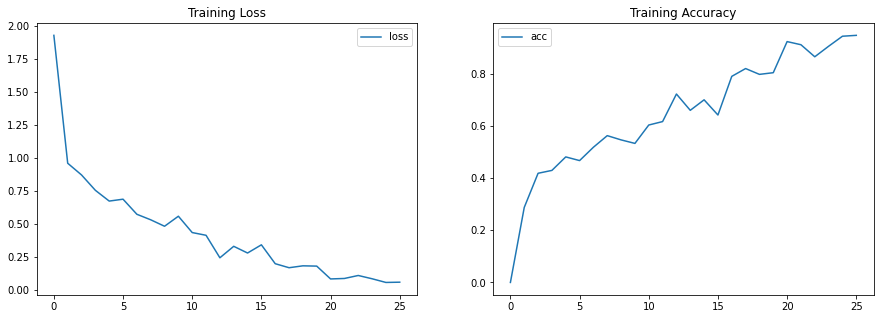

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [38]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = '/content/drive/Shareddrives/pzy970802@gmail.com/training_data/training_ckpt_seq2seq_bigru'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In the prediction step, our input is a secuence of length one, the sos token, then we call the encoder and decoder repeatedly until we get the eos token or reach the maximum length defined.

In [39]:
#预测function
def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_inputs, idx2word_outputs):
  if input_text is None:
    input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
  input_text = preprocess_sentence_zh(input_text)
  input_seq = tokenizer_inputs.texts_to_sequences([input_text])
  input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
  # Set the encoder initial state
  en_initial_states = encoder.init_states(1)
  en_outputs = encoder(tf.constant(input_seq), en_initial_states)
  # Create the decoder input, the sos token
  de_input = tf.constant([[word2idx_outputs['<sos>']]])
  # Set the decoder states to the encoder vector or encoder hidden state
  de_state = en_outputs[1:] #gru

  out_words = []
  while True:
    # Decode and get the output probabilities
    de_output, de_state = decoder(de_input, de_state)  #gru
    # Select the word with the highest probability
    de_input = tf.argmax(de_output, -1)
    # Append the word to the predicted output
    out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
    # Finish when eos token is found or the max length is reached
    if out_words[-1] == '<eos>' or len(out_words) >= 37:
      break
    
  print(' '.join(out_words))

In [40]:
def translate(sentence):
  predict(sentence, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

In [41]:
translate(u'如果明天下雨,那你就在家里吧。')
translate(u'我是一名大学生。')
translate(u'这是一个诚实的孩子。')
translate(u'星期天你打算去哪玩?')
translate(u'晚餐你想吃什么?')
translate(u'明天你记得带雨伞,可能会下雨。')
#以下三条为训练句子
translate(u'我觉得当汤姆发现他买来的画是赝品的时候，他会很生气。')
translate(u'汤姆试过还回泳衣来换成更大一号的，但是员工告诉他那是不被允许的。')
translate(u'在十九世纪三十年代的大萧条时期，许多富人在股市崩盘中失去了一切。')

if you re fine , you ll stay at home . <eos>
i am a student . <eos>
this is a beautiful girl . <eos>
where would you go to the zoo ? <eos>
what do you want for supper ? <eos>
you ll go after see if you leave . <eos>
i think tom is going to be pretty mad when he finds out that the painting he bought is a fake . <eos>
tom tried to return the swimsuit for a larger size , but the clerk told him that wasn t allowed . <eos>
during the depression in the s lost many people s everything s in the eye of the money , but a single poet . <eos>


# **Seq2seq with attention**

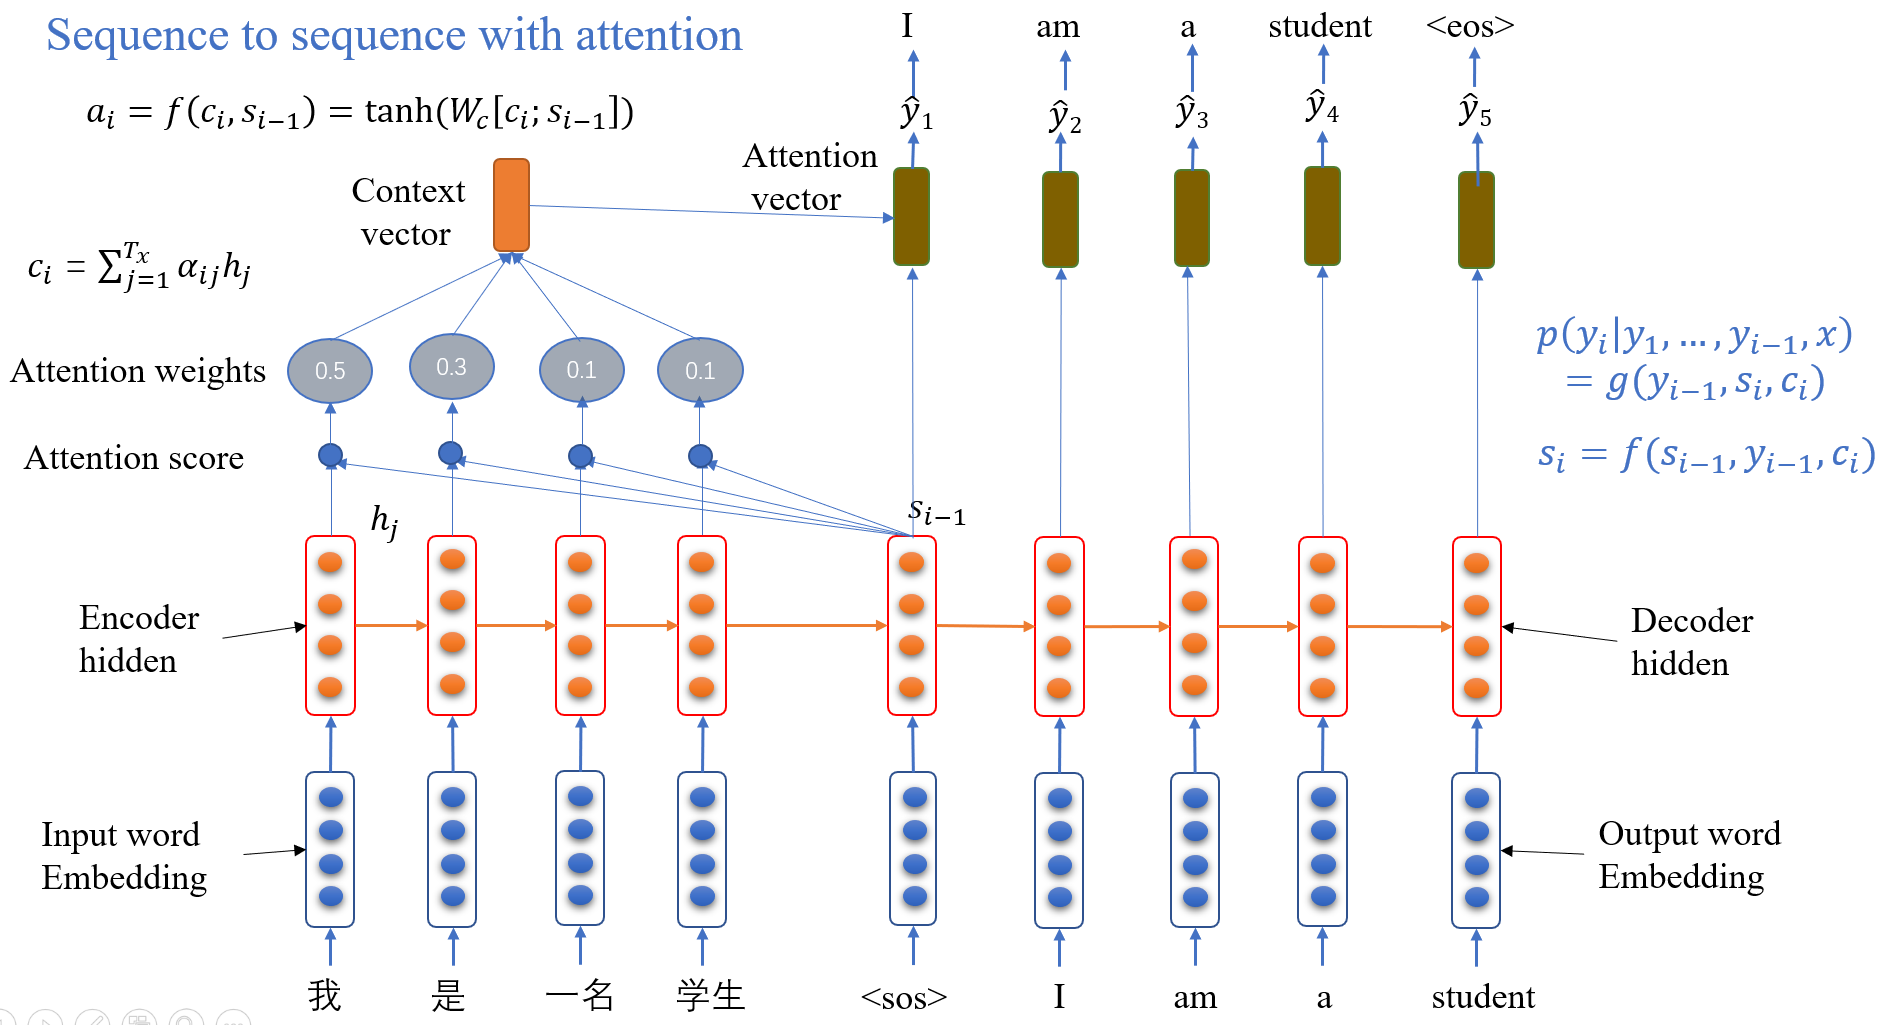

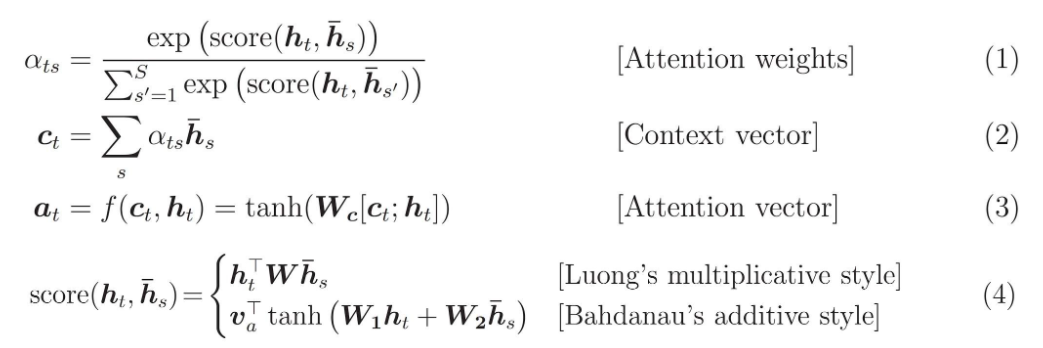

In [42]:
input_sequence_zh = [110,82,221,175,57,5,41,9,458,101,1]
for i in input_sequence_zh:
  print(idx2word_inputs[i], end='')

如果明天下雨,那你就在家里吧。

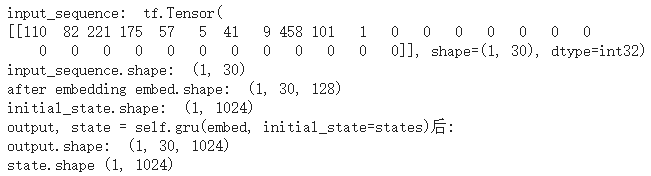

In [43]:
#encoder为gru, 如果是测试seq2seq+attention则下面的return_sequences=True
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.hidden_dim, return_sequences=True, return_state=True)
  
  def call(self, input_sequence, states):
    
    embed = self.embedding(input_sequence)
    output, state = self.gru(embed, initial_state=states)

    return output, state

  def init_states(self, batch_size):
    return tf.zeros([batch_size, self.hidden_dim])

Encoder output shape: (batch size, max length, units)

Encoder Hidden state shape: (batch_size, units)

In [ ]:
#encoder为双向gru
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.bigru =  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.hidden_dim, return_sequences=True, return_state=True))
  
  def call(self, input_sequence, states):
    
    embed = self.embedding(input_sequence)
    output, forward_state, backward_state = self.bigru(embed, initial_state=states)
    state = tf.keras.layers.concatenate([forward_state, backward_state])
    return output, state

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.hidden_dim]),  tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
#@title
#不必运行
tf.keras.layers.Layer.W1 = tf.keras.layers.Dense(4)
tf.keras.layers.Layer.V = tf.keras.layers.Dense(1)

a = tf.constant([[[1,2,3]]])
# a = tf.constant([[1,2,3]])
print(a.shape)
b = tf.keras.layers.Layer.W1(a)
print(b.shape)
print(b)
c = tf.nn.tanh(tf.keras.layers.Layer.W1(a))
print(c)
print(c.shape)
tf.keras.layers.Layer.V(c)

(1, 1, 3)
(1, 1, 4)
tf.Tensor([[[ 0.6256938 -1.942975  -0.9319425 -2.7088535]]], shape=(1, 1, 4), dtype=float32)
tf.Tensor([[[ 0.55507994 -0.9597693  -0.73149836 -0.99116457]]], shape=(1, 1, 4), dtype=float32)
(1, 1, 4)


<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[-0.23617488]]], dtype=float32)>

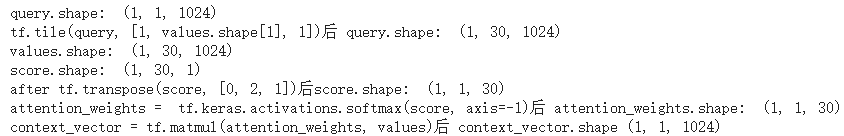

In [44]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # values shape == (batch_size, max_len, hidden_size)
    query = tf.tile(query, [1, values.shape[1], 1])
    # query shape == (batch_size, max_len, hidden size)
    # the shape of the tensor before applying self.V is (batch_size, max_length, 1)
    score = self.V(tf.nn.tanh(self.W1(query) + self.W2(values)))
    score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)
    attention_weights =  tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
    context_vector = tf.matmul(attention_weights, values) #(batch_size, 1, units)

    return context_vector, attention_weights

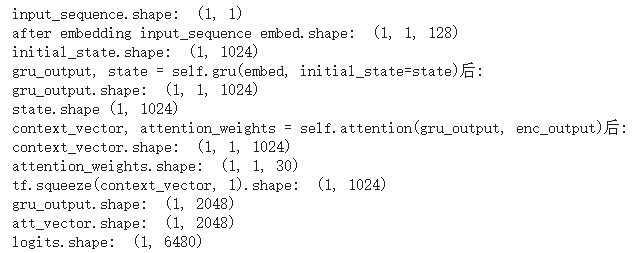

In [45]:
#gru
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units   #双向的话要乘以2
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.wc = tf.keras.layers.Dense(self.dec_units, activation='tanh')
    self.ws = tf.keras.layers.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, input_sequence, state, enc_output):
    # Remember that the input to the decoder
    embed = self.embedding(input_sequence) #embed(batch_size, 1, 128)

    gru_output, state = self.gru(embed, initial_state=state) #gru_output(batch_size,1,1024), state(batch_size, 1024)
    context_vector, attention_weights = self.attention(gru_output, enc_output) #context_vector(batch_size,1,1024), attention_weights(batch_size,1,max_langth)
    gru_output = tf.concat(
            [tf.squeeze(context_vector, 1), tf.squeeze(gru_output, 1)], 1) #gru_output(batch_size,2048)

    att_vector = self.wc(gru_output) #att_vector(1,2048)
    logits = self.ws(att_vector) #logits(batch_size, vocab_size)

    return logits, state, attention_weights

In [47]:
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 

#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
print('num_words_inputs: ', num_words_inputs)
print('num_words_output: ', num_words_output)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)

num_words_inputs:  11322
num_words_output:  6480


In [ ]:
#@title
#this cell助于理解,可不运行
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
targets = [0,1,0]
logits = [[0.1,0.3,0.6],[0.2,0.6,0.2],[0.3,0.5,0.2]]
print(tf.math.equal(targets, 0))
mask = tf.math.logical_not(tf.math.equal(targets, 0)) #逻辑非
print(mask)
mask = tf.cast(mask, dtype=tf.int64)
print(mask)
loss = crossentropy(targets, logits, sample_weight=mask) #weight(0,1,0),首先0.6进行softmax
                               #得到0.4272,然后权重为1,先计算-ln(0.4272) x 1(权重)
print(loss)                          #得到0.8505,后除以3得0.28347

tf.Tensor([ True False  True], shape=(3,), dtype=bool)
tf.Tensor([False  True False], shape=(3,), dtype=bool)
tf.Tensor([0 1 0], shape=(3,), dtype=int64)
tf.Tensor(0.2834748, shape=(), dtype=float32)


In [48]:
def loss_func(targets, logits):
  crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # Mask padding values, they do not have to compute for loss
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64)
  loss = crossentropy(targets, logits, sample_weight=mask)

  return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = tf.cast(tf.math.argmax(y_pred, axis=-1), dtype='int32')
    correct = tf.cast(tf.math.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = tf.cast(tf.math.greater(y_true, 0), dtype='float32')
    n_correct = tf.reduce_sum(mask * correct)
    n_total = tf.reduce_sum(mask)
    
    return n_correct / n_total

In [49]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
  loss = 0.
  acc = 0.
  logits = None

  with tf.GradientTape() as tape:
    en_outputs = encoder(input_seq, en_initial_states)
    en_states = en_outputs[1:]
    # de_state_h, de_state_c = en_states #lstm
    de_state = en_states #gru

    for i in range(target_seq_out.shape[1]):
      decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
      logit, de_state, _ = decoder(decoder_in, de_state, en_outputs[0]) #gru
      loss += loss_func(target_seq_out[:, i], logit)
      logit = tf.expand_dims(logit, axis=1)
      if logits is None:
        logits = logit
      else:
        logits = K.concatenate((logits, logit), axis=1)
    acc = accuracy_fn(target_seq_out, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss / target_seq_out.shape[1], acc

In [50]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
  losses = []
  accuracies = []

  for e in range(n_epochs):
    start = time.time()
    en_initial_states = encoder.init_states(batch_size)
    for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
      # Train and get the loss value 
      loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
      if accuracy >= 0.97:
        return losses, accuracies
      if batch % 100 == 0:
        losses.append(loss)
        accuracies.append(accuracy)
        print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))

    # saving (checkpoint) the model every 2 epochs
    if (e+1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

  return losses, accuracies

In [56]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/Shareddrives/pzy970802@gmail.com/training_data/training_ckpt_seq2seq_att_gru'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [ ]:
losses, accuracies = main_train(encoder, decoder, dataset, 40, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)


Epoch 1 Batch 0 Loss 2.0164 Acc:0.0000
Epoch 1 Batch 100 Loss 1.0582 Acc:0.2745
Epoch 1 Batch 200 Loss 0.8854 Acc:0.3592
Epoch 1 Batch 300 Loss 0.9179 Acc:0.3399
Time taken for 1 epoch 187.1070 sec

Epoch 2 Batch 0 Loss 0.8060 Acc:0.4049
Epoch 2 Batch 100 Loss 0.7147 Acc:0.4517
Epoch 2 Batch 200 Loss 0.6673 Acc:0.4686
Epoch 2 Batch 300 Loss 0.6721 Acc:0.4532
Time taken for 1 epoch 152.4850 sec

Epoch 3 Batch 0 Loss 0.5183 Acc:0.5394
Epoch 3 Batch 100 Loss 0.5410 Acc:0.5147
Epoch 3 Batch 200 Loss 0.5588 Acc:0.5327
Epoch 3 Batch 300 Loss 0.5555 Acc:0.5288
Time taken for 1 epoch 151.5108 sec

Epoch 4 Batch 0 Loss 0.4498 Acc:0.6113
Epoch 4 Batch 100 Loss 0.5035 Acc:0.5812
Epoch 4 Batch 200 Loss 0.3926 Acc:0.6461
Epoch 4 Batch 300 Loss 0.3424 Acc:0.6792
Time taken for 1 epoch 152.7713 sec

Epoch 5 Batch 0 Loss 0.2669 Acc:0.7216
Epoch 5 Batch 100 Loss 0.3032 Acc:0.7048
Epoch 5 Batch 200 Loss 0.3306 Acc:0.6954
Epoch 5 Batch 300 Loss 0.2955 Acc:0.7091
Time taken for 1 epoch 151.4867 sec

Epoch

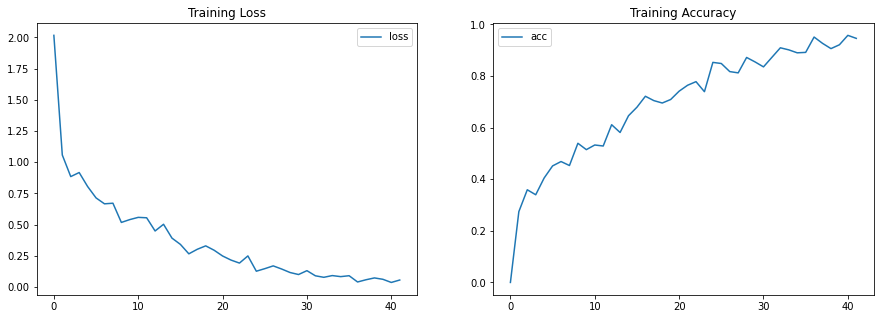

In [ ]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [57]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/Shareddrives/pzy970802@gmail.com/training_data/training_ckpt_seq2seq_att_gru'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
#@title
import numpy as np
import tensorflow as tf
beam_length=30
def length_of_beam(beam_result, end_token):
    for i, token in enumerate(beam_result):
        if token == end_token:
            return i+1
    return len(beam_result)

def beam_step(beam_width, step, decoder, dec_input, dec_hidden, enc_outputs, 
              end_token, vocab_size, score):
  
    # First beam step
    if step == 1:
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_outputs)
        print(attention_weights.shape)
        predictions = np.exp(predictions[0])/sum(np.exp(predictions[0]))
        predictions = tf.math.log(predictions)
        values, indices = tf.math.top_k(predictions, k=beam_width)
        dec_input_t = tf.concat([tf.broadcast_to(dec_input, [beam_width,1]), tf.expand_dims(indices,1)], axis=1)
        dec_hidden = tf.broadcast_to(dec_hidden, [beam_width,dec_hidden.shape[1]])
        score_t = values
        dec_hidden_t = dec_hidden
        attention_weights = tf.reshape(attention_weights, (-1, ))

        return dec_input_t, dec_hidden_t, score_t, attention_weights
    
    beams_ended = []
    
    # Generate next set of predictions from the previous beams
    predictions, dec_hidden, attention_weights = decoder(tf.expand_dims(dec_input[:,step-1],1), dec_hidden, enc_outputs)
    attention_weights = tf.reshape(attention_weights, (-1, ))
    scores = predictions.numpy()
    scores_length_normalized = np.zeros(scores.shape)
    for b in range(beam_width):
        if dec_input[b,step-1] == end_token:
            # Beam has already reached end token
            beams_ended.append(b)
            # Set first value as the previous beam score and rest as -ve inf 
            # for all the tokens generated from the ended beam
            scores[b] = np.append([score[b]], [-np.inf] * (vocab_size-1))
        else:
            # Beam hasn't reached end token
            scores[b] = np.exp(scores[b])/sum(np.exp(scores[b]))
            scores[b] = tf.math.log(scores[b])
            scores[b] = scores[b] + score[b]
        # Length normalization of beam
        scores_length_normalized[b] = scores[b] / np.power(length_of_beam(dec_input[b],end_token), 0.7)
     
    # Initializing next set of inputs for beam step    
    dec_input_t = np.zeros([beam_width, step+1])
    dec_hidden_t = dec_hidden
    score_t = np.zeros([beam_width])
    
    # Unrolling scores    
    scores = np.reshape(scores, (1,-1))
    scores_length_normalized = np.reshape(scores_length_normalized, (1,-1))
    values, indices = tf.math.top_k(scores_length_normalized[0], k=beam_width)
    
    for i, index in enumerate(indices):
        beam = index//vocab_size
        if beam.numpy() in beams_ended:
            # If the beam has already ended append end token
            dec_input_t[i] = np.append(dec_input[beam], [end_token])
        else:
            # If beam hasn't ended add the next token which gives higher score
            dec_input_t[i,:] = np.append(dec_input[beam,:], [index%vocab_size])
        score_t[i] = scores[0][index]
    
    return dec_input_t, dec_hidden_t, score_t, attention_weights


def beam_search(beam_width, decoder, dec_input, dec_hidden, enc_outputs, end_token, vocab_size):
    score = None
    attention_weights = []
    for t in range(1,beam_length):
        dec_input, dec_hidden, score, attention_weight = beam_step(beam_width, t, decoder, dec_input, 
                                        dec_hidden, enc_outputs, end_token, vocab_size, score)
        attention_weights.append(attention_weight.numpy())
    
    best_beam = tf.argmax(score)
    output = []
    for token in dec_input[best_beam]:
        output.append(token)
        if token == end_token:
            break
    return output, attention_weights

In [ ]:
#@title
#beam search
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    input_text = preprocess_sentence_zh(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state = en_outputs[1:]
    
    beam_width = 1
    output_vocab_size = num_words_output
    # out_words = []
    output_words, attention_weights = beam_search(beam_width, decoder, de_input, de_state, 
                         en_outputs[0], word2idx_outputs['<eos>'], output_vocab_size)
   
    return np.array(attention_weights), input_text.split(' '), output_words

import matplotlib.ticker as ticker

def translate(sentences):

  # Create the figure to plot in
  fig = plt.figure(figsize=(10, 20))

  for i, test_sent in enumerate(sentences):
      # Call the predict function to get the translation
      alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                      word2idx_outputs, idx2word_outputs)
      print(alignments.shape)
      attention = alignments
      # attention = np.squeeze(alignments,(1,2))
      # # Create a subplot
      ax = fig.add_subplot(1, 1, i+1)
      print(attention[0])
      ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
      ax.set_xticklabels([''] + source,  fontproperties=zhfont)
      ax.set_yticklabels([''] + prediction)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
      prediction = np.array(prediction,dtype=int)
      
      for i in prediction:
        print(''.join(idx2word_outputs[i]),end=' ')
      print('')

  # plt.show()

In [58]:
#greed_search
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    input_text = preprocess_sentence_zh(input_text)
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    en_initial_states = encoder.init_states(1) #批大小设为1
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state = en_outputs[1:]
    
    out_words = []
    attention_weights = []

    while True:
        # Get the decoder with attention output
        de_output, de_state, attention_weight = decoder(
            de_input, de_state, en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        attention_weights.append(attention_weight.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 37:
            break
    # Join the output words
    print(' '.join(out_words))
    return np.array(attention_weights), input_text.split(' '), out_words

import matplotlib.ticker as ticker
def translate(sentences):

  fig = plt.figure(figsize=(10, 10))

  for i, test_sent in enumerate(sentences):
      # Call the predict function to get the translation
      alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                     word2idx_outputs, idx2word_outputs)
      attention = np.squeeze(alignments,(1,2))
      ax = fig.add_subplot(1, 1, i+1)
      ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
      ax.set_xticklabels([''] + source,  fontproperties=zhfont)
      ax.set_yticklabels([''] + prediction)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

In [59]:
# matplotlib显示中文
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
import matplotlib.pyplot as plt
import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

--2021-01-05 10:46:59--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  20.2MB/s    in 0.5s    

2021-01-05 10:47:00 (20.2 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



if it rains tomorrow , you ll be in home . <eos>
i am a college student . <eos>
this is an honest child . <eos>
where do you go to school on sunday ? <eos>
what would you like for supper ? <eos>
you remember seeing the umbrella tomorrow . it ll rain . <eos>
i think that tom is going to be pretty mad when he finds out that the painting he bought is a fake . <eos>
tom tried to return the swimsuit for a larger size , but the clerk told him that wasn t allowed . <eos>
during the depression in the depression is all over the difficult stock market . <eos>


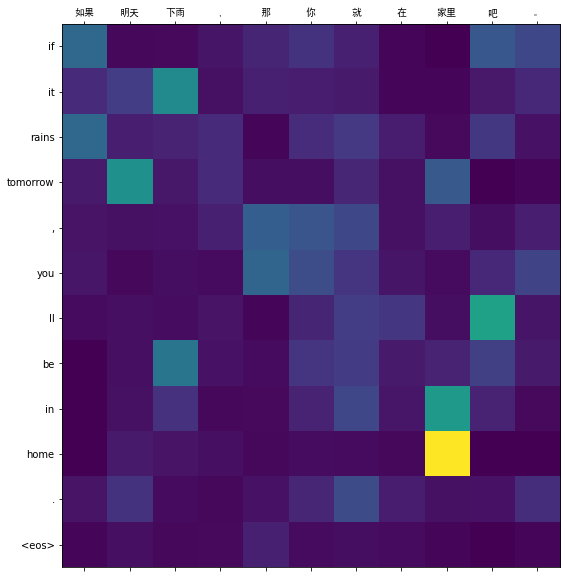

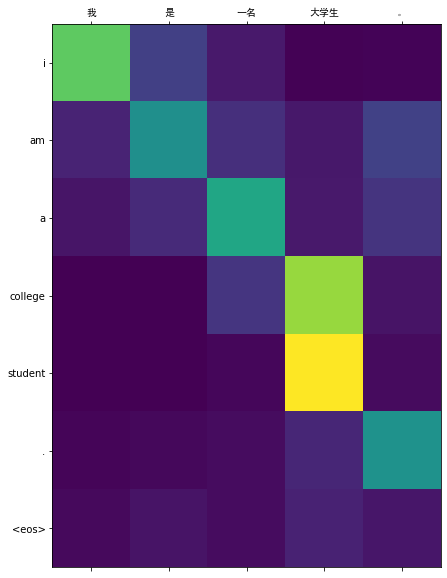

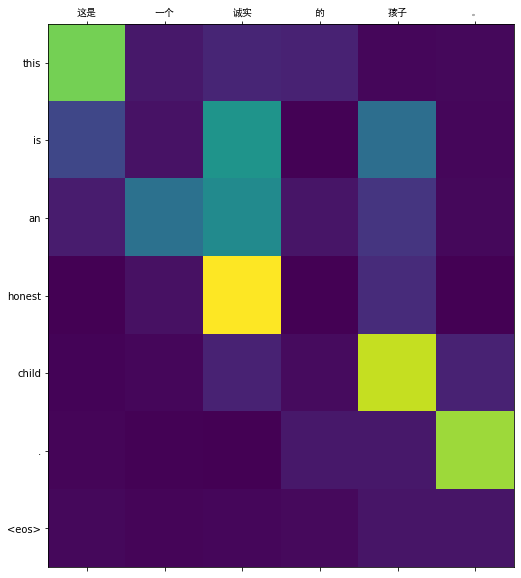

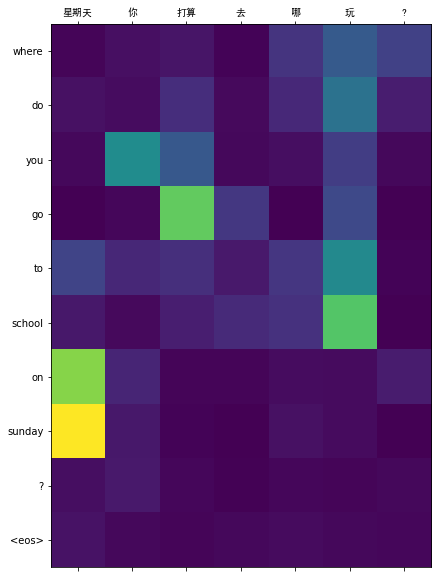

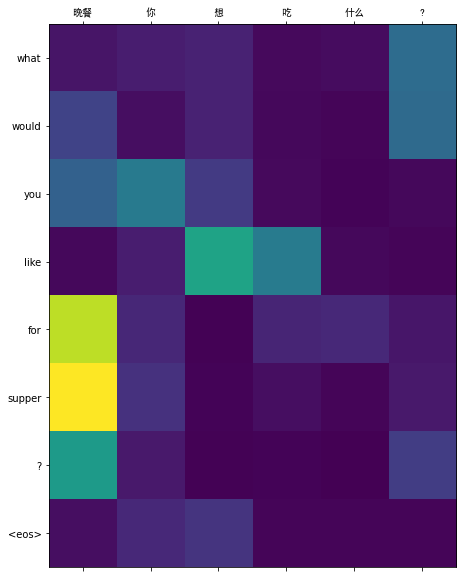

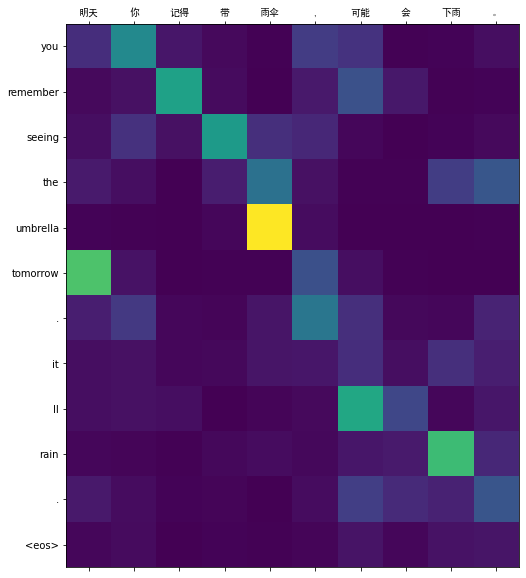

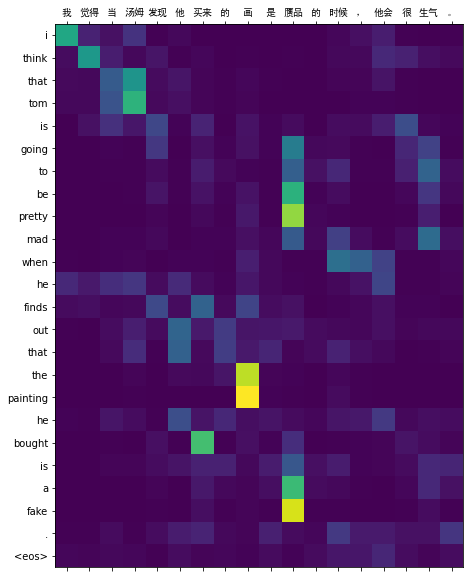

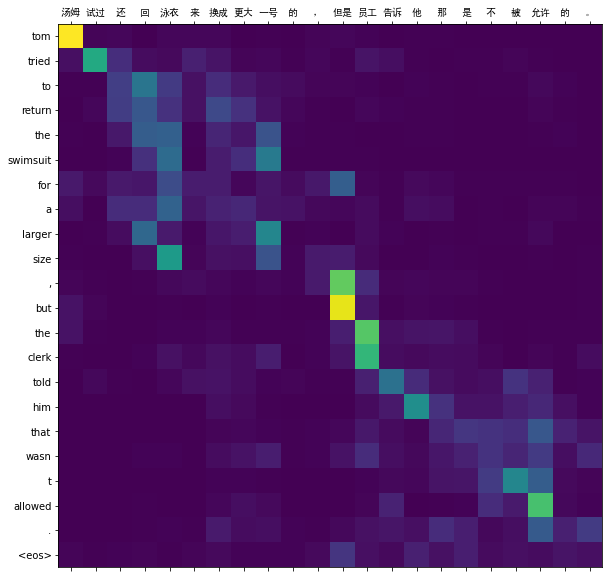

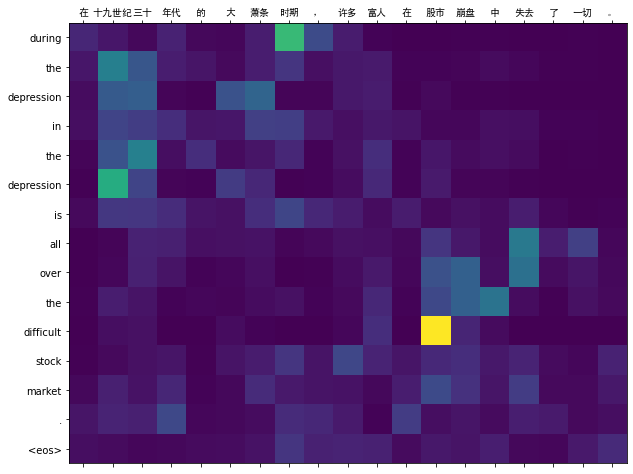

In [60]:
translate([u'如果明天下雨,那你就在家里吧。'])
translate([u'我是一名大学生。'])
translate([u'这是一个诚实的孩子。'])
translate([u'星期天你打算去哪玩?'])
translate([u'晚餐你想吃什么?'])
translate([u'明天你记得带雨伞,可能会下雨。'])
translate([u'我觉得当汤姆发现他买来的画是赝品的时候，他会很生气。'])
translate([u'汤姆试过还回泳衣来换成更大一号的，但是员工告诉他那是不被允许的。'])
translate([u'在十九世纪三十年代的大萧条时期，许多富人在股市崩盘中失去了一切。'])